# How to work with the N5 API and ImgLib2?
> Read and write ImgLib2 data with the N5 API

- toc: false
- branch: master
- badges: true
- comments: true
- author: Stephan Saalfeld
- categories: [imglib2, n5, hdf5, zarr, jupyter, notebook]

In this notebook, we will learn how to work with the [N5 API](https://github.com/saalfeldlab/n5) and [ImgLib2](https://imglib2.net).

The N5 API unifies block-wise access to potentially very large *n*-dimensional data over a variety of storage backends.  Those backends currently are the simple [N5 format on the local filesystem](https://github.com/saalfeldlab/n5#file-system-specification), [Google Cloud](https://github.com/saalfeldlab/n5-google-cloud) and [AWS-S3](https://github.com/saalfeldlab/n5-aws-s3), the [HDF5 file format](https://www.hdfgroup.org/solutions/hdf5/) and [Zarr](https://github.com/saalfeldlab/n5-zarr).  The [ImgLib2 bindings](https://github.com/saalfeldlab/n5-imglib2) use this API to make this data available as memory cached lazy cell images through ImgLib2.

This notebook uses code and data examples from the [ImgLib2 large data tutorial](https://www.janelia.org/sites/default/files/You%20%2B%20Janelia/Conferences/3.pdf) [I2K2020 workshop](https://www.janelia.org/you-janelia/conferences/from-images-to-knowledge-with-imagej-friends) ([GitHub repository](https://github.com/saalfeldlab/i2k2020-imglib2-advanced)).

First let's add the necessary dependencies.  We will load the [`n5-ij` module](https://github.com/saalfeldlab/n5-ij) which will transitively load [ImgLib2](https://imglib2.net) and all the N5 API modules that we will be using in this notebook.  It will also load [ImageJ](https://imagej.nih.gov/ij/) which we will use to display data.

In [1]:
%%loadFromPOM
<repository>
    <id>scijava.public</id>
    <url>https://maven.scijava.org/content/groups/public</url>
</repository>
<dependency>
    <groupId>org.janelia.saalfeldlab</groupId>
    <artifactId>n5</artifactId>
    <version>2.5.1</version>
</dependency>
<dependency>
    <groupId>org.janelia.saalfeldlab</groupId>
    <artifactId>n5-ij</artifactId>
    <version>3.2.2</version>
</dependency>

Now, we register a simple renderer that uses [ImgLib2's ImageJ bridge](https://github.com/imglib/imglib2-ij/blob/master/src/main/java/net/imglib2/img/display/imagej/ImageJFunctions.java) and [Spencer Park's image renderer](https://github.com/SpencerPark/jupyter-jvm-basekernel/blob/master/src/main/java/io/github/spencerpark/jupyter/kernel/display/common/Image.java) to render the first 2D slice of a `RandomAccessibleInterval` into the notebook.  We also add a renderer for arrays and maps, because we want to list directories and attributes maps later.

In [2]:
import com.google.gson.*;
import io.github.spencerpark.jupyter.kernel.display.common.*;
import io.github.spencerpark.jupyter.kernel.display.mime.*;
import net.imglib2.img.display.imagej.*;
import net.imglib2.view.*;
import net.imglib2.*;

getKernelInstance().getRenderer().createRegistration(RandomAccessibleInterval.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((rai, context) -> Image.renderImage(
                ImageJFunctions.wrap(rai, rai.toString()).getBufferedImage(),
                context));

getKernelInstance().getRenderer().createRegistration(String[].class)
        .preferring(MIMEType.TEXT_PLAIN)
        .supporting(MIMEType.TEXT_HTML, MIMEType.TEXT_MARKDOWN)
        .register((array, context) -> Text.renderCharSequence(Arrays.toString(array), context));

getKernelInstance().getRenderer().createRegistration(long[].class)
        .preferring(MIMEType.TEXT_PLAIN)
        .supporting(MIMEType.TEXT_HTML, MIMEType.TEXT_MARKDOWN)
        .register((array, context) -> Text.renderCharSequence(Arrays.toString(array), context));

getKernelInstance().getRenderer().createRegistration(Map.class)
        .preferring(MIMEType.TEXT_PLAIN)
        .supporting(MIMEType.TEXT_HTML, MIMEType.TEXT_MARKDOWN)
        .register((map, context) -> Text.renderCharSequence(map.toString(), context));


We will now open N5 datasets from some sources as lazy-loading ImgLib2 cell images.  For opening the N5 readers, we will use the helper class [`N5Factory`](https://github.com/saalfeldlab/n5-ij/blob/eb9f2aa38e676c36ac79fc26ac8bec4905c1a7fb/src/main/java/org/janelia/saalfeldlab/n5/ij/N5Factory.java) which parses the URL and/ or some magic byte in file headers to pick the right reader or writer for the various possible N5 backends.  If you know which backend you are using, you should probably use the appropriate implementation directly, it's not difficult.

log4j:WARN No appenders could be found for logger (com.amazonaws.auth.AWSCredentialsProviderChain).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.


Could not load AWS credentials, falling back to anonymous.


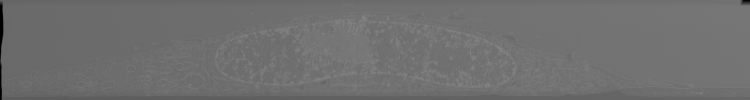

In [3]:
import ij.*;
import net.imglib2.converter.*;
import net.imglib2.type.numeric.integer.*;
import org.janelia.saalfeldlab.n5.*;
import org.janelia.saalfeldlab.n5.ij.*;
import org.janelia.saalfeldlab.n5.imglib2.*;

/* make an N5 reader, we start with a public container on AWS S3 */
final var n5Url = "https://janelia-cosem.s3.amazonaws.com/jrc_hela-2/jrc_hela-2.n5";
final var n5Group = "/em/fibsem-uint16";
final var n5Dataset = n5Group + "/s4";
final var n5 = new N5Factory().openReader(n5Url);

/* open a dataset as a lazy loading ImgLib2 cell image */
final RandomAccessibleInterval<UnsignedShortType> rai = N5Utils.open(n5, n5Dataset);

/* This is a 3D volume, so let's show the center slice */
Views.hyperSlice(rai, 2, rai.dimension(2) / 2);

That's a bit low on contrast, let's make it look like TEM, and let's show a few of those hyperslices through the 3D volume:

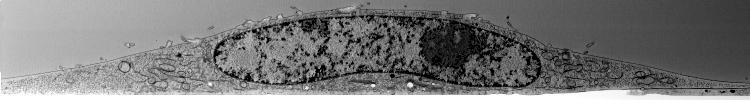

6e32749d-48d5-4c52-be9b-41c43bae02f4

In [4]:
var raiContrast = Converters.convert(
        rai,
        (a, b) -> b.setReal(Math.max(0, Math.min(255, 255 - 255 * (a.getRealDouble() - 26000) / 6000))),
        new UnsignedByteType());
display(Views.hyperSlice(raiContrast, 2, rai.dimension(2) / 10 * 4), "image/jpeg");
display(Views.hyperSlice(raiContrast, 2, rai.dimension(2) / 2), "image/jpeg");
display(Views.hyperSlice(raiContrast, 2, rai.dimension(2) / 10 * 6), "image/jpeg");

We can list the attributes and their types of every group or dataset, and read any of them into matching types:

In [5]:
var groupAttributes = n5.listAttributes(n5Group);
var datasetAttributes = n5.listAttributes(n5Dataset);

display(
    "**" + n5Group + "** attributes are ```" +
        groupAttributes.toString().replace(", ", ",\n").replace("{", "{\n") + "```",
    "text/markdown");
display(
    "**" + n5Dataset + "** attributes are ```" +
        datasetAttributes.toString().replace(", ", ",\n").replace("{", "{\n") + "```",
    "text/markdown");

var n5Version = n5.getAttribute("/", "n5", String.class);
var dimensions = n5.getAttribute(n5Dataset, "dimensions", long[].class);
var compression = n5.getAttribute(n5Dataset, "compression", Compression.class);
var dataType = n5.getAttribute(n5Dataset, "dataType", DataType.class);

display(n5Version);
display(dimensions);
display(compression);
display(dataType);



**/em/fibsem-uint16** attributes are ```{
pixelResolution=class java.lang.Object,
multiscales=class [Ljava.lang.Object;,
n5=class java.lang.String,
scales=class [Ljava.lang.Object;,
axes=class [Ljava.lang.String;,
name=class java.lang.String,
units=class [Ljava.lang.String;}```

**/em/fibsem-uint16/s4** attributes are ```{
transform=class java.lang.Object,
pixelResolution=class java.lang.Object,
dataType=class java.lang.String,
name=class java.lang.String,
compression=class java.lang.Object,
blockSize=class [J,
dimensions=class [J}```

2.0.0

[750, 100, 398]

org.janelia.saalfeldlab.n5.GzipCompression@673562cc

uint16

6c5c9bc2-ea28-4685-9658-a8fbf3c65df4

Let's save the contrast adjusted uin8 version of the volume into three N5 supported containers (N5, Zarr, and HDF5), parallelize writing for N5 and Zarr:

In [6]:
import java.nio.file.*;

/* create a temporary directory */
Path tmpDir = Files.createTempFile("", "");
Files.delete(tmpDir);
Files.createDirectories(tmpDir);
var tmpDirStr = tmpDir.toString();

display(tmpDirStr);

/* get the dataset attributes (dataType, compression, blockSize, dimensions) */
final var attributes = n5.getDatasetAttributes(n5Dataset);

/* use 10 threads to parallelize copy */
final var exec = Executors.newFixedThreadPool(10);

/* save this dataset into a filsystem N5 container */
try (final var n5Out = new N5Factory().openFSWriter(tmpDirStr + "/test.n5")) {
    N5Utils.save(raiContrast, n5Out, n5Dataset, attributes.getBlockSize(), attributes.getCompression(), exec);
}

/* save this dataset into a filesystem Zarr container */
try (final var zarrOut = new N5Factory().openZarrWriter(tmpDirStr + "/test.zarr")) {
    N5Utils.save(raiContrast, zarrOut, n5Dataset, attributes.getBlockSize(), attributes.getCompression(), exec);
}

/* save this dataset into an HDF5 file, parallelization does not help here */
try (final var hdf5Out = new N5Factory().openHDF5Writer(tmpDirStr + "/test.hdf5")) {
    N5Utils.save(raiContrast, hdf5Out, n5Dataset, attributes.getBlockSize(), attributes.getCompression());
}

/* shot down the executor service */
exec.shutdown();

display(Files.list(tmpDir).map(a -> a.toString()).toArray(String[]::new));

/tmp/303790804299695858

[/tmp/303790804299695858/test.hdf5, /tmp/303790804299695858/test.n5, /tmp/303790804299695858/test.zarr]

d55081b3-d9fd-4208-9bae-181c9253712a

Now let us look at them and see if they all contain the same data:

In [7]:
try (final var n5 = new N5Factory().openReader(tmpDirStr + "/test.n5")) {
    final RandomAccessibleInterval<UnsignedByteType> rai = N5Utils.open(n5, n5Dataset);
    display(Views.hyperSlice(rai, 2, rai.dimension(2) / 2), "image/jpeg");
}

try (final var n5 = new N5Factory().openReader(tmpDirStr + "/test.zarr")) {
    final RandomAccessibleInterval<UnsignedByteType> rai = N5Utils.open(n5, n5Dataset);
    display(Views.hyperSlice(rai, 2, rai.dimension(2) / 2), "image/jpeg");    
}

try (final var n5 = new N5Factory().openReader(tmpDirStr + "/test.hdf5")) {
    final RandomAccessibleInterval<UnsignedByteType> rai = N5Utils.open(n5, n5Dataset);
    display(Views.hyperSlice(rai, 2, rai.dimension(2) / 2), "image/jpeg");        
}

Let's clean up temporary storage before we end this tutorial.

In [8]:
try (var n5 = new N5Factory().openWriter(tmpDirStr + "/test.n5")) {
    n5.remove();
}
try (var n5 = new N5Factory().openWriter(tmpDirStr + "/test.zarr")) {
    n5.remove();
}
try (var n5 = new N5Factory().openWriter(tmpDirStr + "/test.hdf5")) {
    n5.remove();
}
Files.delete(tmpDir);